STEP 1. CLEANING DATASETS

STEP 1.1 Cleaning Tucson Police Reported Crimes

In [13]:
import pandas as pd

# Load the dataset
file_path = 'Tucson_Police_Reported_Crimes.csv' 
tucson_crimes = pd.read_csv(file_path)

# Step 1: Dropping unnecessary columns
columns_to_drop = ['IncidentID', 'ESRI_OID', 'Year', 'Month', 'Day', 'Division', 'CallSource']
tucson_crimes_cleaned = tucson_crimes.drop(columns=columns_to_drop)

# Step 2: Handling missing values
# Drop rows where critical geographic or source fields are missing
tucson_crimes_cleaned = tucson_crimes_cleaned.dropna(subset=['Ward'])

# Step 3: Converting Ward to integer
tucson_crimes_cleaned['Ward'] = tucson_crimes_cleaned['Ward'].astype(int)

# Step 4: Converting date and time fields to proper datetime format
tucson_crimes_cleaned['DateOccurred'] = pd.to_datetime(tucson_crimes_cleaned['DateOccurred'], errors='coerce')
tucson_crimes_cleaned['TimeOccur'] = tucson_crimes_cleaned['TimeOccur'].apply(lambda x: str(x).zfill(4))

# Drop rows with invalid dates
tucson_crimes_cleaned = tucson_crimes_cleaned.dropna(subset=['DateOccurred'])

# Step 5: Removing duplicates
tucson_crimes_cleaned = tucson_crimes_cleaned.drop_duplicates()

# Display the cleaned dataset
print("Cleaned Dataset:")
print(tucson_crimes_cleaned.head())

# Save the cleaned dataset to a new CSV file
output_file_path = 'Tucson_Crimes_Cleaned.csv'  # Specify the output file path
tucson_crimes_cleaned.to_csv(output_file_path, index=False)


Cleaned Dataset:
               DateOccurred TimeOccur  Ward  UCR            UCRDescription  \
0 2018-03-30 00:00:00+00:00      2054     6    5             05 - BURGLARY   
1 2018-06-15 00:00:00+00:00      0243     1    1             01 - HOMICIDE   
2 2018-01-01 00:00:00+00:00      0412     3    3              03 - ROBBERY   
3 2018-01-01 00:00:00+00:00      0324     1    4  04 - ASSAULT, AGGRAVATED   
4 2018-01-01 00:00:00+00:00      0950     5    6              06 - LARCENY   

   Offense                           OffenseDescription  
0      501                             Burglary - Force  
1      101                   Criminal Homicide - Murder  
2      304                 Robbery - Convenience Stores  
3      413  Aggravated Assault - Domestic Violence (DV)  
4      610                          Larceny - All Other  


STEP 1.2 Cleaning Streetlights data, transforming longitude and latitude from ESPG:2223 to ESPG:4326 
        (later is used to identify wards)

In [14]:
from pyproj import Transformer

# Load the original streetlights data
file_path = 'streetlights.csv'
streetlights_data = pd.read_csv(file_path)

# Drop rows with missing or NaN longitude or latitude
streetlights_data_cleaned = streetlights_data.dropna(subset=['Longitude', 'Latitude'])

# Define the transformer to convert from EPSG:2223 to EPSG:4326 (WGS84)
transformer_to_wgs84 = Transformer.from_crs("EPSG:2223", "EPSG:4326", always_xy=True)

# Transform the coordinates
streetlights_data_cleaned['Longitude_Transformed'], streetlights_data_cleaned['Latitude_Transformed'] = zip(
    *streetlights_data_cleaned.apply(
        lambda row: transformer_to_wgs84.transform(row['Longitude'], row['Latitude']), axis=1
    )
)

# Save the transformed data to a new CSV file
output_path_transformed = 'streetlights_transformed.csv'
streetlights_data_cleaned.to_csv(output_path_transformed, index=False)

output_path_transformed


'streetlights_transformed.csv'

STEP 1.3 Using longitude and latitude (ESPG:4326) to find wards. Additional file was downloaded from City of Tucson Data Hub.
To run: pip install geopandas

In [15]:
import geopandas as gpd

# Define file paths
wards_file_path = "City_of_Tucson_Ward_Boundaries.geojson"
streetlights_file_path = "streetlights_transformed.csv"
output_file = "streetlights_with_wards.csv"

# Load the ward boundaries as a GeoDataFrame
wards = gpd.read_file(wards_file_path)

# Ensure CRS is set to WGS84 (EPSG:4326) if not already defined
if wards.crs is None:
    wards = wards.set_crs(epsg=4326)

# Load the streetlights data
streetlights = pd.read_csv(streetlights_file_path)

# Convert streetlights DataFrame to a GeoDataFrame
# 'Longitude_Transformed' and 'Latitude_Transformed' are used for geometry
streetlights_gdf = gpd.GeoDataFrame(
    streetlights,
    geometry=gpd.points_from_xy(streetlights.Longitude_Transformed, streetlights.Latitude_Transformed),
    crs="EPSG:4326"
)

# Perform a spatial join to find the ward each streetlight belongs to
joined = gpd.sjoin(streetlights_gdf, wards, how="left", predicate="within")

# Extract relevant columns (e.g., 'Longitude_Transformed', 'Latitude_Transformed', and 'WARD')
result = joined[["Longitude_Transformed", "Latitude_Transformed", "WARD"]]

# Save the resulting dataset
result.to_csv(output_file, index=False)

# Display success message and first few rows
print(f"Result saved to {output_file}")
print(result.head())


Result saved to streetlights_with_wards.csv
   Longitude_Transformed  Latitude_Transformed WARD
0            -110.943296             32.153723    5
1            -110.943592             32.153405    5
2            -110.943300             32.153082    5
3            -110.943597             32.152760    5
4            -110.943295             32.152523    5


STEP 1.4. Merging Tucson Police Reported Crimes and Streetlights

In [16]:
# Load data
crime_data = pd.read_csv('Tucson_Crimes_Cleaned.csv')
streetlights_data = pd.read_csv('streetlights_with_wards.csv')

# Adjust column names
if 'Ward' in crime_data.columns:
    crime_data.rename(columns={'Ward': 'WARD_CRIMES'}, inplace=True)

if 'WARD' in streetlights_data.columns:
    streetlights_data.rename(columns={'WARD': 'WARD_STREETLIGHTS'}, inplace=True)

# Combine columns from both datasets
combined_data = pd.concat([crime_data, streetlights_data], axis=1)

# Save the combined file
combined_file_path = 'Merged_Tucson_Crime_and_Streetlight_Data.csv'
combined_data.to_csv(combined_file_path, index=False)

combined_file_path


'Merged_Tucson_Crime_and_Streetlight_Data.csv'

STEP 1.5 Cleaning Neighborhood dataset and merging with Tucson Police Reported Crime

In [20]:
# Load the dataset
neighborhood_income_path = 'Neighborhood_Income.csv'
neighborhood_income = pd.read_csv(neighborhood_income_path)

# Step 1: Select relevant columns for socioeconomic analysis
socioeconomic_columns = ['NAME', 'WARD', 'TOTHH_CY', 'WLTHINDXCY', 'MEDHINC_CY', 'AVGHINC_CY']
neighborhood_income_cleaned = neighborhood_income[socioeconomic_columns].copy()

# Step 2: Handle missing values
for column in socioeconomic_columns[2:]:  # Skip 'NAME' and 'WARD'
    if neighborhood_income_cleaned[column].isnull().sum() > 0:
        neighborhood_income_cleaned[column] = neighborhood_income_cleaned[column].fillna(
            neighborhood_income_cleaned[column].median()
        )

# Step 3: Remove duplicates
neighborhood_income_cleaned = neighborhood_income_cleaned.drop_duplicates()

# Step 4: Rename columns for clarity
neighborhood_income_cleaned.rename(columns={
    'NAME': 'Neighborhood_Name',
    'WARD': 'Ward',
    'TOTHH_CY': 'Total_Households',
    'WLTHINDXCY': 'Wealth_Index',
    'MEDHINC_CY': 'Median_Income',
    'AVGHINC_CY': 'Average_Income'
}, inplace=True)

# Step 5: Save cleaned dataset to a new file
output_path = 'Neighborhood_Income_Socioeconomic_Cleaned.csv'
neighborhood_income_cleaned.to_csv(output_path, index=False)

print("Data cleaning completed and saved to:", output_path)

Data cleaning completed and saved to: Neighborhood_Income_Socioeconomic_Cleaned.csv


In [21]:
# Load datasets
ward_boundaries_file = "City_of_Tucson_Ward_Boundaries.csv"
income_file = "Neighborhood_Income_Socioeconomic_Cleaned.csv"
crimes_file = "Tucson_Crimes_Cleaned.csv"

ward_boundaries_data = pd.read_csv(ward_boundaries_file)
income_data = pd.read_csv(income_file)
crimes_data = pd.read_csv(crimes_file)

# Print column names to verify
print("Ward Boundaries Columns:", ward_boundaries_data.columns)
print("Income Data Columns:", income_data.columns)
print("Crimes Data Columns:", crimes_data.columns)

# Correct column renaming
ward_boundaries_data.rename(columns={"WARD": "Ward"}, inplace=True)

# Ensure consistent column naming for other datasets
income_data.rename(columns={"Ward": "Ward"}, inplace=True)
crimes_data.rename(columns={"Ward": "Ward"}, inplace=True)

# Ensure 'Ward' columns are strings
ward_boundaries_data['Ward'] = ward_boundaries_data['Ward'].astype(str).str.strip()
income_data['Ward'] = income_data['Ward'].astype(str).str.strip()
crimes_data['Ward'] = crimes_data['Ward'].astype(str).str.strip()

# Step 2: Aggregate crime data by Ward and UCRDescription
ucr_counts_by_ward = crimes_data.groupby(['Ward', 'UCRDescription']).size().reset_index(name='Crime_Count')

# Pivot the data to create UCRDescription counts as columns for each ward
ucr_pivot = ucr_counts_by_ward.pivot(index='Ward', columns='UCRDescription', values='Crime_Count').fillna(0).reset_index()

# Step 3: Aggregate income data by Ward
income_data_by_ward = income_data.groupby('Ward').agg({
    'Total_Households': 'sum',
    'Wealth_Index': 'mean',
    'Median_Income': 'mean',
    'Average_Income': 'mean'
}).reset_index()

# Step 4: Merge all datasets based on Ward
# Merge ward boundaries with income data
ward_income_merged = pd.merge(ward_boundaries_data, income_data_by_ward, on='Ward', how='inner')

# Merge the result with crime data
final_merged_data = pd.merge(ward_income_merged, ucr_pivot, on='Ward', how='inner')

# Step 5: Select essential columns for hypothesis analysis
essential_columns = [
    'Ward', 'Total_Households', 'Wealth_Index', 'Median_Income', 'Average_Income'
] + list(ucr_pivot.columns[1:])  # Include all UCRDescription counts

final_essential_data = final_merged_data[essential_columns]

# Save the final data to a CSV file
output_file = "Final_Ward_Analysis_Data.csv"
final_essential_data.to_csv(output_file, index=False)

print(f"The essential dataset for hypotheses analysis has been saved to {output_file}")

Ward Boundaries Columns: Index(['OBJECTID', 'WARD', 'NAME', 'PHONE', 'URL', 'ADDRESS', 'KEYID', 'UNIT',
       'DATASOURCE', 'City', 'State', 'Zipcode', 'Label', 'GlobalID',
       'created_user', 'created_date', 'last_edited_user', 'last_edited_date',
       'ShapeSTArea', 'ShapeSTLength'],
      dtype='object')
Income Data Columns: Index(['Neighborhood_Name', 'Ward', 'Total_Households', 'Wealth_Index',
       'Median_Income', 'Average_Income'],
      dtype='object')
Crimes Data Columns: Index(['DateOccurred', 'TimeOccur', 'Ward', 'UCR', 'UCRDescription', 'Offense',
       'OffenseDescription'],
      dtype='object')
The essential dataset for hypotheses analysis has been saved to Final_Ward_Analysis_Data.csv


STEP 2 Data Visualization

Converting time to correct format %H:%M

In [22]:
import matplotlib.pyplot as plt

# Load the dataset
merged_data_path = 'Merged_Tucson_Crime_and_Streetlight_Data.csv'
merged_data = pd.read_csv(merged_data_path)

# Function to clean and parse `TimeOccur`
def parse_time(time):
    try:
        # Remove leading/trailing whitespace and handle empty strings
        time = str(time).strip()
        if not time:  # Handle blank or empty strings
            return None
        
        # Handle colon-separated time (e.g., 8:30)
        if ':' in time:
            return pd.to_datetime(time, format='%H:%M').time()
        
        # Handle integer time (e.g., 2408 or 815)
        time_str = str(int(float(time))).zfill(4)  # Ensure it's a 4-digit string
        
        # Normalize 24-hour format (e.g., 2408 to 00:08)
        hour = int(time_str[:2])
        minute = int(time_str[2:])
        if hour == 24:
            hour = 0
        if hour > 23 or minute > 59:
            raise ValueError("Invalid time")
        return pd.to_datetime(f"{hour:02d}:{minute:02d}", format='%H:%M').time()
    except Exception as e:
        print(f"Error parsing time: {time}, Error: {e}")
        return None

merged_data['TimeOccur'] = merged_data['TimeOccur'].apply(parse_time)

# Drop rows where time parsing failed
merged_data = merged_data.dropna(subset=['TimeOccur'])

# Filter rows where time is between 18:00 and 04:00
def is_night_time(time):
    return (time >= pd.to_datetime("18:00", format='%H:%M').time() or
            time < pd.to_datetime("04:00", format='%H:%M').time())

merged_data = merged_data[merged_data['TimeOccur'].apply(is_night_time)]

# Save the cleaned and filtered dataset to a new CSV file
cleaned_data_path = 'Cleaned_Tucson_Crime_and_Streetlight_Data.csv'
merged_data.to_csv(cleaned_data_path, index=False)
print(f"Cleaned and filtered dataset saved to {cleaned_data_path}")


Cleaned and filtered dataset saved to Cleaned_Tucson_Crime_and_Streetlight_Data.csv


Visualizatioins for crime and streetlights

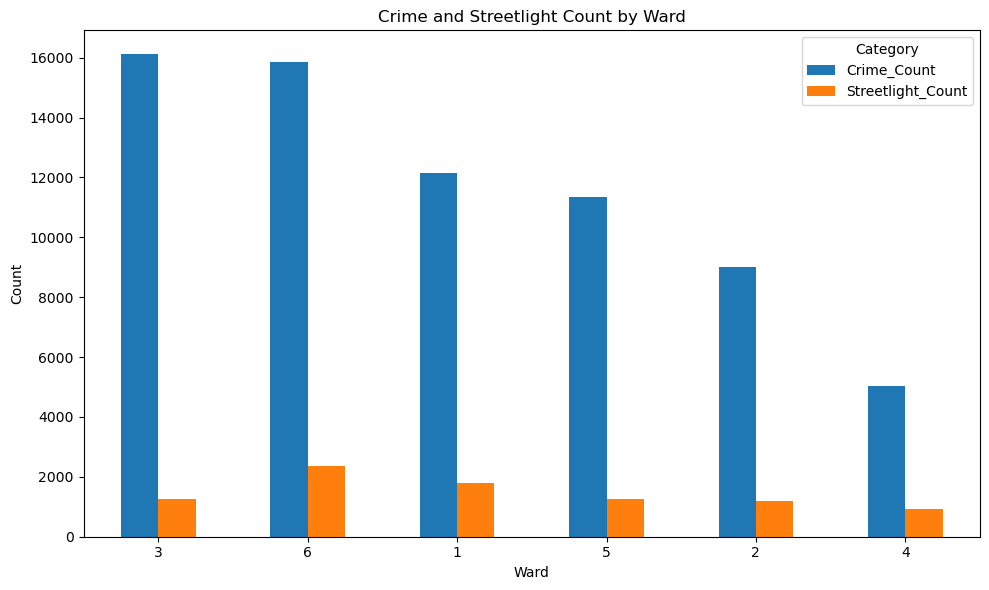

In [23]:
#Visualization 1
# Load the merged dataset
merged_data_path = 'Cleaned_Tucson_Crime_and_Streetlight_Data.csv'
merged_data = pd.read_csv(merged_data_path)

# Group by WARD_CRIMES and WARD_STREETLIGHTS to find counts
ward_crime_data = merged_data['WARD_CRIMES'].value_counts().reset_index()
ward_crime_data.columns = ['Ward', 'Crime_Count']

ward_streetlights_data = merged_data['WARD_STREETLIGHTS'].value_counts().reset_index()
ward_streetlights_data.columns = ['Ward', 'Streetlight_Count']

# Merge the two datasets on Ward
ward_analysis = pd.merge(ward_crime_data, ward_streetlights_data, on='Ward', how='outer')

# Visualization
ward_analysis.plot(x='Ward', y=['Crime_Count', 'Streetlight_Count'], kind='bar', figsize=(10, 6))
plt.title('Crime and Streetlight Count by Ward')
plt.xlabel('Ward')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Category')
plt.tight_layout()
plt.show()

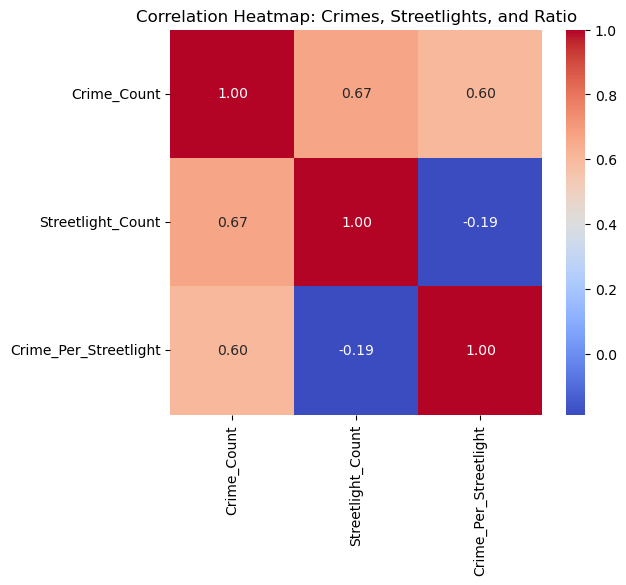

In [24]:
# Visualization 2
import seaborn as sns

# Load the dataset
file_path = 'Cleaned_Tucson_Crime_and_Streetlight_Data.csv'
data = pd.read_csv(file_path)

# Separate relevant data
crime_data = data[["WARD_CRIMES"]].copy()
streetlight_data = data[["WARD_STREETLIGHTS"]].copy()

# Aggregating data by ward
crime_by_ward = crime_data["WARD_CRIMES"].value_counts().reset_index()
crime_by_ward.columns = ["WARD", "Crime_Count"]

streetlights_by_ward = streetlight_data["WARD_STREETLIGHTS"].value_counts().reset_index()
streetlights_by_ward.columns = ["WARD", "Streetlight_Count"]

# Merge the two aggregated datasets based on the "WARD"
ward_data = pd.merge(crime_by_ward, streetlights_by_ward, on="WARD", how="inner")



# Visualization 3: Correlation Heatmap - Crimes, Streetlights, and Ratios
ward_data["Crime_Per_Streetlight"] = ward_data["Crime_Count"] / ward_data["Streetlight_Count"]
corr_matrix = ward_data[["Crime_Count", "Streetlight_Count", "Crime_Per_Streetlight"]].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Crimes, Streetlights, and Ratio")
plt.show()


Visualizations for crime

In [33]:
# Load the merged dataset
file_path = 'Final_Ward_Analysis_Data.csv'  # Ensure your dataset is uploaded to Colab
data = pd.read_csv(file_path)

# Step 1: Summarize total crimes by ward and by type
ucr_summary_by_ward = data.drop(columns=['Total_Households', 'Wealth_Index', 'Median_Income', 'Average_Income'])
ucr_summary = ucr_summary_by_ward.set_index('Ward').sum(axis=0)
crime_proportions = ucr_summary / ucr_summary.sum()

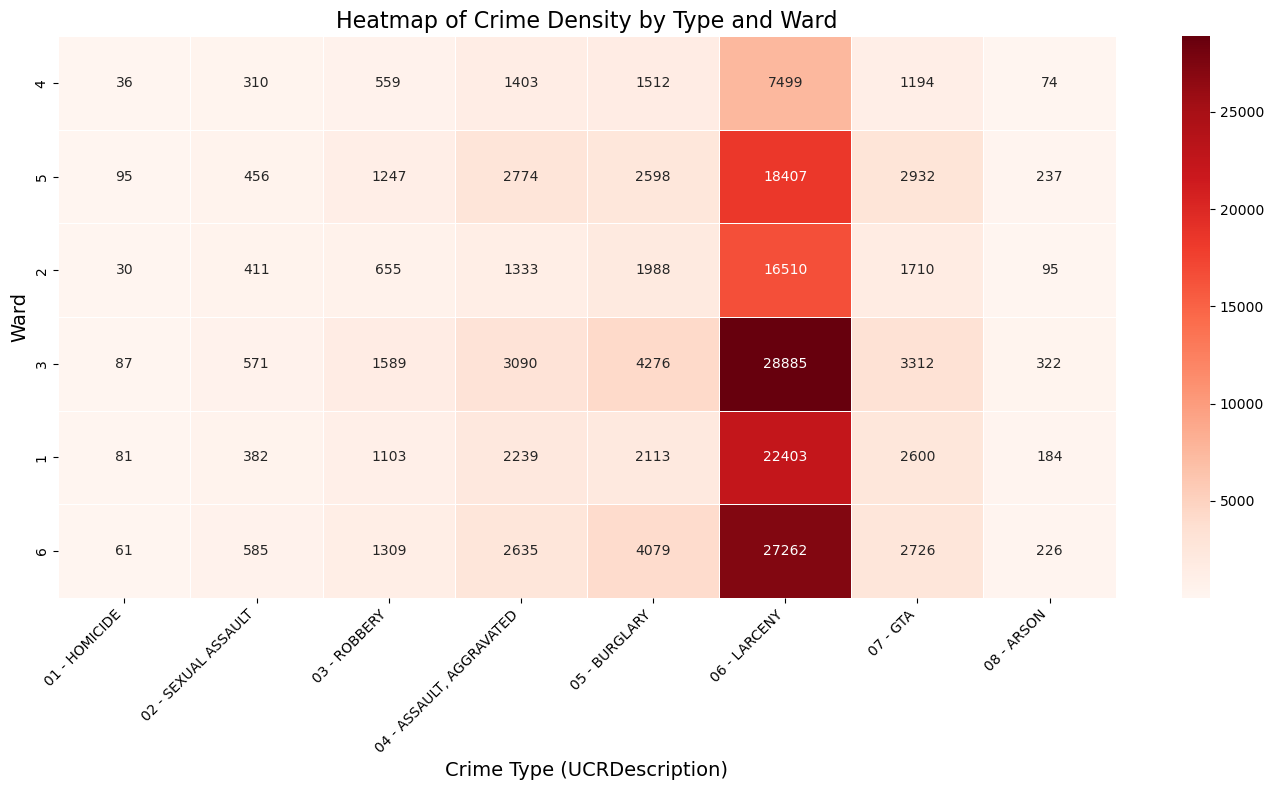

In [26]:
# Step 2: Heatmap of crimes by ward and type
plt.figure(figsize=(14, 8))
sns.heatmap(ucr_summary_by_ward.set_index('Ward'), annot=True, cmap="Reds", fmt=".0f", linewidths=0.5)
plt.title("Heatmap of Crime Density by Type and Ward", fontsize=16)
plt.xlabel("Crime Type (UCRDescription)", fontsize=14)
plt.ylabel("Ward", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

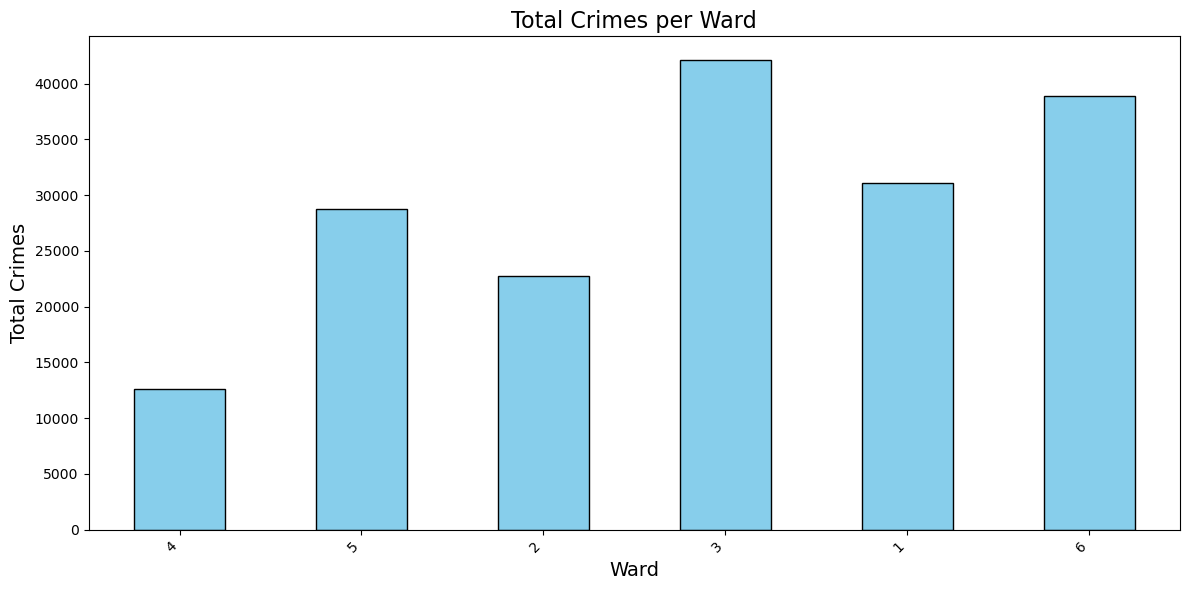

In [30]:
# Step 3: Bar chart of total crimes per ward
ward_totals = ucr_summary_by_ward.set_index('Ward').sum(axis=1)
plt.figure(figsize=(12, 6))
ward_totals.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Total Crimes per Ward", fontsize=16)
plt.xlabel("Ward", fontsize=14)
plt.ylabel("Total Crimes", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

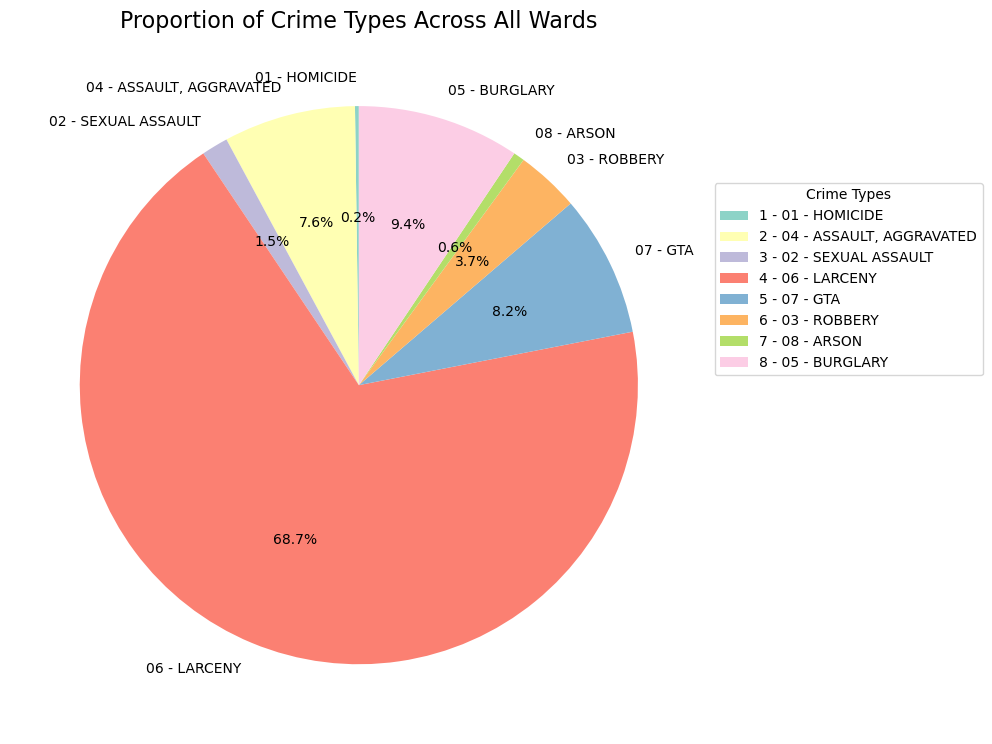

In [34]:
# Rearrange the order of categories as specified: 1,4,2,6,7,3,8,5
reordered_indices = [0, 3, 1, 5, 6, 2, 7, 4]  # Indices for the desired order

# Reorder the crime proportions based on specified order
reordered_crime_proportions = crime_proportions.iloc[reordered_indices]

# Plot the adjusted pie chart with the specified order
plt.figure(figsize=(10, 10))
colors = plt.cm.Set3.colors  # Use a defined color palette
reordered_crime_proportions.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    labels=reordered_crime_proportions.index
)
plt.title("Proportion of Crime Types Across All Wards", fontsize=16)
plt.ylabel("")  # Remove default ylabel

# Add a legend for clarity
legend_labels = [f"{i+1} - {crime_type}" for i, crime_type in enumerate(reordered_crime_proportions.index)]
plt.legend(legend_labels, loc="upper left", bbox_to_anchor=(1, 0.8), title="Crime Types")
plt.tight_layout()

# Show the adjusted pie chart
plt.show()

Normalized Ward Summary:
       Total_Crimes  Median_Income  Average_Income
Ward                                             
1         0.755046       0.640073        0.665417
2         0.973373       0.960232        1.000000
3         0.682851       0.504128        0.589971
4         1.000000       1.000000        0.952725
5         0.643118       0.549005        0.583777
6         0.946926       0.801987        0.918334


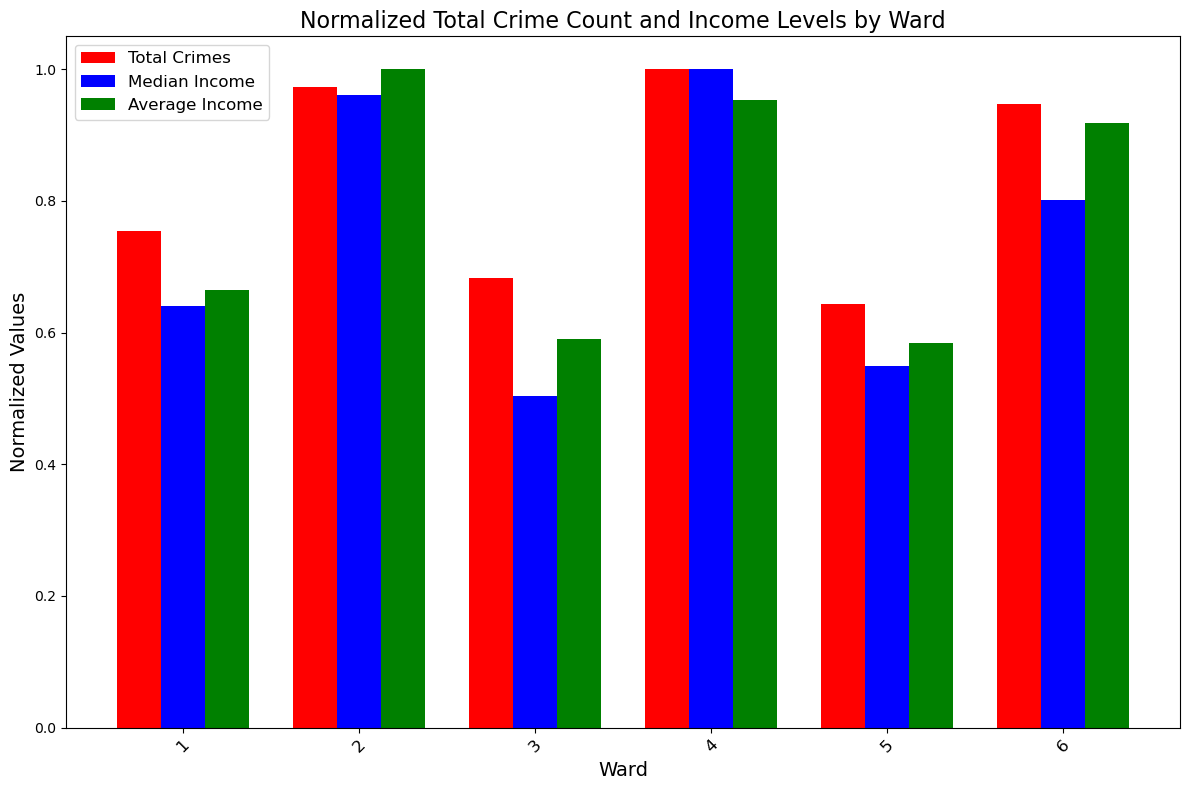

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = 'Final_Ward_Analysis_Data.csv'
data = pd.read_csv(file_path)

# Calculate total crime occurrences for each ward
data['Total_Crimes'] = data.iloc[:, 1:9].sum(axis=1)

# Group data by Ward and calculate mean values for each group
ward_summary = data.groupby('Ward')[
    ['Total_Crimes', 'Median_Income', 'Average_Income']
].mean()

# Normalize the data for comparison
ward_summary_normalized = ward_summary.copy()
ward_summary_normalized['Total_Crimes'] /= ward_summary['Total_Crimes'].max()
ward_summary_normalized['Median_Income'] /= ward_summary['Median_Income'].max()
ward_summary_normalized['Average_Income'] /= ward_summary['Average_Income'].max()

# Print normalized values for debugging
print("Normalized Ward Summary:\n", ward_summary_normalized)

# Create a clustered bar chart
bar_width = 0.25
index = np.arange(len(ward_summary_normalized))

plt.figure(figsize=(12, 8))

# Plot bars for each metric
plt.bar(index, ward_summary_normalized['Total_Crimes'], bar_width, label='Total Crimes', color='red')
plt.bar(index + bar_width, ward_summary_normalized['Median_Income'], bar_width, label='Median Income', color='blue')
plt.bar(index + 2 * bar_width, ward_summary_normalized['Average_Income'], bar_width, label='Average Income', color='green')

# Adding labels and title
plt.title('Normalized Total Crime Count and Income Levels by Ward', fontsize=16)
plt.xlabel('Ward', fontsize=14)
plt.ylabel('Normalized Values', fontsize=14)
plt.xticks(index + bar_width, ward_summary.index, rotation=45, fontsize=12)
plt.legend(fontsize=12)

# Display the chart
plt.tight_layout()
plt.show()

STEP 3 Modeling, Prediction and Evaluation

Linear Regression - Cross-validated R²: 0.82 ± 0.09
Linear Regression - Cross-validated MSE: 92362722.35
Linear Regression - Final MSE: 13841243.97, Final R²: 0.98
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Random Forest - Cross-validated R²: 0.87 ± 0.10
Random Forest - Cross-validated MSE: 66834073.16
Random Forest - Final MSE: 6851218.75, Final R²: 0.99
Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


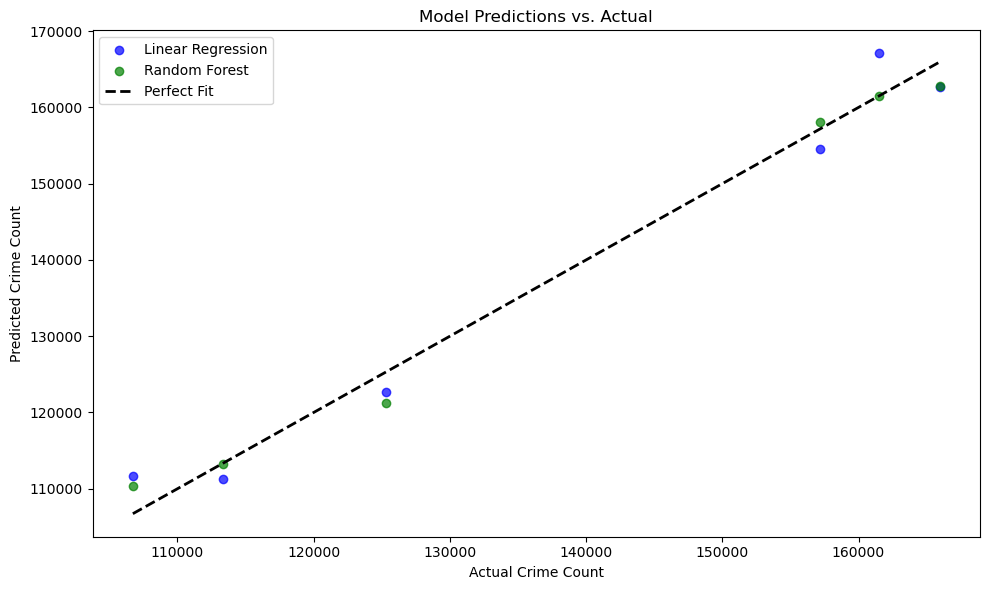

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = 'Final_Ward_Analysis_Data.csv'  # Adjust the path
data = pd.read_csv(file_path)

# Calculate total crime occurrences for each ward
data['Total_Crimes'] = data.iloc[:, 1:9].sum(axis=1)

# Group data by Ward and calculate mean values for each group
ward_summary = data.groupby('Ward')[['Total_Crimes', 'Median_Income', 'Average_Income']].mean()

# Features and target variable
X = ward_summary[['Median_Income', 'Average_Income']].values
y = ward_summary['Total_Crimes'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use k-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Linear Regression
lin_reg = LinearRegression()
cv_r2_lr = cross_val_score(lin_reg, X_scaled, y, cv=kf, scoring='r2')
cv_mse_lr = -cross_val_score(lin_reg, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')

lin_reg.fit(X_scaled, y)  # Fit on the entire dataset for final predictions
y_pred_lr = lin_reg.predict(X_scaled)
final_mse_lr = mean_squared_error(y, y_pred_lr)
final_r2_lr = r2_score(y, y_pred_lr)

print(f"Linear Regression - Cross-validated R²: {cv_r2_lr.mean():.2f} ± {cv_r2_lr.std():.2f}")
print(f"Linear Regression - Cross-validated MSE: {cv_mse_lr.mean():.2f}")
print(f"Linear Regression - Final MSE: {final_mse_lr:.2f}, Final R²: {final_r2_lr:.2f}")

# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(rf_reg, param_grid, cv=kf, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_scaled, y)

# Best model
best_rf = grid_search.best_estimator_
cv_r2_rf = cross_val_score(best_rf, X_scaled, y, cv=kf, scoring='r2')
cv_mse_rf = -cross_val_score(best_rf, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')

y_pred_rf = best_rf.predict(X_scaled)
final_mse_rf = mean_squared_error(y, y_pred_rf)
final_r2_rf = r2_score(y, y_pred_rf)

print(f"Random Forest - Cross-validated R²: {cv_r2_rf.mean():.2f} ± {cv_r2_rf.std():.2f}")
print(f"Random Forest - Cross-validated MSE: {cv_mse_rf.mean():.2f}")
print(f"Random Forest - Final MSE: {final_mse_rf:.2f}, Final R²: {final_r2_rf:.2f}")
print(f"Best Random Forest Parameters: {grid_search.best_params_}")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_lr, label='Linear Regression', alpha=0.7, color='blue')
plt.scatter(y, y_pred_rf, label='Random Forest', alpha=0.7, color='green')
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Crime Count')
plt.ylabel('Predicted Crime Count')
plt.title('Model Predictions vs. Actual')
plt.legend()
plt.tight_layout()
plt.show()